In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from keras import layers
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns


from pneumonia.ml_logic.preprocessor import train_generator, val_generator, test_generator
from pneumonia.ml_logic.baseline import compile, fitting
from tensorflow.keras.layers import Rescaling
from tensorflow.keras import Input

from keras.applications.densenet import DenseNet121
from keras.layers import GlobalAveragePooling2D
from keras.models import Model
from keras import backend as K


In [2]:
train_datagen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rescale=1.0/255.0,
    dtype='float32'
)

val_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    dtype='float32'
)

test_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    dtype='float32'
)

train_generator = train_datagen.flow_from_directory(
    directory=r"/Users/simrankaurvohra/code/anya9889/pneumonia_diagnosis/original_data/train",
    target_size=(256,256),
    color_mode="rgb",
    batch_size=32,
    class_mode="binary",
    shuffle=True,
    seed=42
)

val_generator = val_datagen.flow_from_directory(
    directory=r"/Users/simrankaurvohra/code/anya9889/pneumonia_diagnosis/original_data/val",
    target_size=(256,256),
    color_mode="rgb",
    batch_size=32,
    class_mode="binary",
    shuffle=True,
    seed=42
)

test_generator = test_datagen.flow_from_directory(
    directory=r"/Users/simrankaurvohra/code/anya9889/pneumonia_diagnosis/original_data/test",
    target_size=(256,256),
    color_mode="rgb",
    batch_size=32,
    class_mode="binary",
    shuffle=True,
    seed=42
)

Found 4716 images belonging to 2 classes.
Found 604 images belonging to 2 classes.
Found 548 images belonging to 2 classes.


In [3]:
def dense_net():
    model = DenseNet121(input_shape=(256, 256, 3), include_top=False, weights='imagenet', pooling='avg')
    model.trainable = False
    
    x = layers.Flatten()(model.output)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.2)(x)

    # Add a final sigmoid layer with 1 node for classification output
    x = layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.models.Model(model.input, x)
    return model

In [4]:
def compile(model):
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy', Recall()])
    print(model.summary())
    return model

In [9]:
def fitting(model):
    es = EarlyStopping(patience=5)
    history = model.fit(
        train_generator, epochs=10, validation_data=val_generator, 
        verbose=True, callbacks=[es]
    )
    return history

In [10]:
dense_model_history = fitting(dense_model)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 262, 262, 3)  0          ['input_2[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 128, 128, 64  9408        ['zero_padding2d_2[0][0]']       
                                )                                                           

2023-03-23 14:48:09.181995: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


148/148 [==============================] - ETA: 0s - loss: 0.2103 - accuracy: 0.9143 - recall_1: 0.9444

2023-03-23 14:49:10.438486: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


148/148 [==============================] - 71s 447ms/step - loss: 0.2103 - accuracy: 0.9143 - recall_1: 0.9444 - val_loss: 0.1964 - val_accuracy: 0.9089 - val_recall_1: 0.9326
Epoch 2/10
148/148 [==============================] - 62s 417ms/step - loss: 0.1461 - accuracy: 0.9444 - recall_1: 0.9645 - val_loss: 0.1491 - val_accuracy: 0.9404 - val_recall_1: 0.9640
Epoch 3/10
148/148 [==============================] - 63s 421ms/step - loss: 0.1408 - accuracy: 0.9432 - recall_1: 0.9630 - val_loss: 0.1778 - val_accuracy: 0.9238 - val_recall_1: 0.9169
Epoch 4/10
148/148 [==============================] - 61s 413ms/step - loss: 0.1233 - accuracy: 0.9493 - recall_1: 0.9674 - val_loss: 0.1924 - val_accuracy: 0.9172 - val_recall_1: 0.9798
Epoch 5/10
148/148 [==============================] - 61s 414ms/step - loss: 0.1388 - accuracy: 0.9470 - recall_1: 0.9645 - val_loss: 0.1366 - val_accuracy: 0.9437 - val_recall_1: 0.9551
Epoch 6/10
148/148 [==============================] - 60s 407ms/step - loss:

Text(0.5, 1.0, 'Accuracy Evolution')

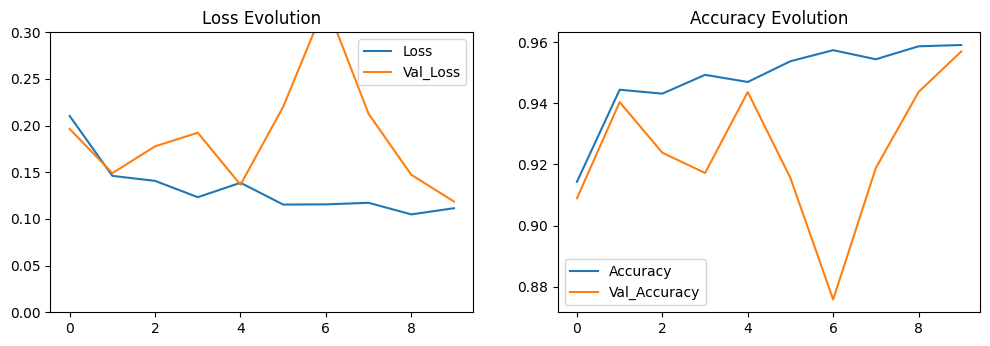

In [11]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(dense_model_history.history['loss'], label='Loss')
plt.plot(dense_model_history.history['val_loss'], label='Val_Loss')
plt.ylim(0, 0.3)
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(dense_model_history.history['accuracy'], label='Accuracy')
plt.plot(dense_model_history.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')